# Data Extraction Transformation and Loading (ETL) Pipeline

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date 
from google.cloud import storage
from pyspark import StorageLevel
from pyspark.sql import SparkSession

## Google Storage

We will list the files in the Google Storage bucket.

In [2]:
storage_client = storage.Client(project="bigdata-410322")

In [3]:
buckets = storage_client.list_buckets()
print("Buckets:")
for bucket in buckets:
    print(bucket.name)
print("Listed all storage buckets.")

Buckets:
bigdata-410322.appspot.com
data_collection_bucket
staging.bigdata-410322.appspot.com
Listed all storage buckets.


In [4]:
# get bucket
bucket = storage_client.get_bucket("data_collection_bucket")
blobs = bucket.list_blobs(prefix="goodreads/")

for blob in blobs:
    print(blob.name)

goodreads/
goodreads/book_id_map.csv
goodreads/goodreads_book_authors.json.gz
goodreads/goodreads_book_genres_initial.json.gz
goodreads/goodreads_book_series.json.gz
goodreads/goodreads_book_works.json.gz
goodreads/goodreads_books.json.gz
goodreads/goodreads_books_children.json.gz
goodreads/goodreads_books_comics_graphic.json.gz
goodreads/goodreads_books_fantasy_paranormal.json.gz
goodreads/goodreads_books_history_biography.json.gz
goodreads/goodreads_books_mystery_thriller_crime.json.gz
goodreads/goodreads_books_poetry.json.gz
goodreads/goodreads_books_romance.json.gz
goodreads/goodreads_books_young_adult.json.gz
goodreads/goodreads_interactions.csv
goodreads/goodreads_interactions_children.json.gz
goodreads/goodreads_interactions_comics_graphic.json.gz
goodreads/goodreads_interactions_dedup.json.gz
goodreads/goodreads_interactions_fantasy_paranormal.json.gz
goodreads/goodreads_interactions_history_biography.json.gz
goodreads/goodreads_interactions_mystery_thriller_crime.json.gz
goodr

## Reading the data via spark

Now we will read the data from the Google Storage bucket using the spark. There are many files, so we will focus on the following files:

- `goodreads/goodreads_books.json.gz`

In [4]:
# hadoop configuration
# latest version of gcs-connector-hadoop3 is not recommened for production
spark = SparkSession.builder \
    .appName('ai-powered-search') \
    .config("spark.jars", "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "12g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/19 10:19:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
print("Spark Version:" + spark.version)

Spark Version:3.5.1


In [7]:
print(f"Hadoop version = {spark._sc._jvm.org.apache.hadoop.util.VersionInfo.getVersion()}")

Hadoop version = 3.3.4


In [5]:
# set crentials
# Set GCS credentials if necessary
spark._jsc.hadoopConfiguration().set(
    "google.cloud.auth.service.account.json.keyfile",
    "gcs-secrets.json")

In [6]:
# read data, it will take some time - around 60 seconds
bucket_name = "data_collection_bucket"
file_path = f"gs://{bucket_name}/goodreads/goodreads_books.json.gz"

books = spark.read.json(file_path)

In [10]:
books.printSchema()

root
 |-- asin: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- author_id: string (nullable = true)
 |    |    |-- role: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- book_id: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- description: string (nullable = true)
 |-- edition_information: string (nullable = true)
 |-- format: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- is_ebook: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: string (nullable = true)
 |-- kindle_asin: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- link: string (nullable = true)
 |-- num_pages: string (nullable = true)
 |-- popular_shelves: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- count: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- pub

In [27]:
# it around 2 minutes to run
books.describe().toPandas()

,summary,asin,average_rating,book_id,country_code,description,edition_information,format,image_url,is_ebook,...,publication_day,publication_month,publication_year,publisher,ratings_count,text_reviews_count,title,title_without_series,url,work_id
0,count,2360655,2360655,2360655,2360655,2360655,2360655,2360655,2360655,2360655,...,2360655,2360655,2360655,2360655,2360655,2360655,2360655,2360655,2360655,2360655
1,mean,6.6170195601576395E9,3.865792441182683,1.5409527218918901E7,None,1.6316489590649722E12,1.0932477766297789E10,208.0,None,None,...,12.100377481054851,6.422773074554547,2007.6144852728232,Infinity,406.307368531662,28.086682900228844,Infinity,Infinity,None,2.074910529208633E7
2,stddev,3.9894892570530663E9,0.5406797641219261,1.0818966681787824E7,None,3.7514592201379785E12,3.268587417054502E11,44.54211490264017,None,None,...,10.005777584828621,3.4244416135997713,248.07579162968696,NaN,11126.34738973136,378.7806470544982,NaN,NaN,None,1.9117373085523047E7
3,min,,,1,,,,,,,...,,,,,,,,,,
4,max,www.amazon,5.00,9999995,US,"Vi kien truc su tai hoa nam nao khong con, nh...",,zip,https://s.gr-assets.com/assets/nophoto/book/11...,true,...,9,9,9999,|Pimlico,9999,999,［新釈］養生訓,［新釈］養生訓,https://www.goodreads.com/book/show/9999995-ci...,999994


The above table gives a very good overview of the data. We notice that 
some columns have _inconsistent_ data types. For example, we have an url in `asin` column. It is interesting that `spark` is able to calculate the average even though when the column is string. For instance, `average_rating` is a string column but we can still calculate the average. This is because `spark` is able to convert the string to a number when it is needed.

When I view the data, sometimes I will use `toPandas()` method to display the data in a more readable format. However, this is not recommended for large datasets as it will bring all the data to the driver node. It is better to use `show()` method to display the data._So, if you see some results are not very readable, it is because I am using `show()` method to display the data._

In [25]:
books.limit(5).toPandas()

,asin,authors,average_rating,book_id,country_code,description,edition_information,format,image_url,is_ebook,...,publication_year,publisher,ratings_count,series,similar_books,text_reviews_count,title,title_without_series,url,work_id
0,,"[(604031, )]",4.00,5333265,US,,,Paperback,https://images.gr-assets.com/books/1310220028m...,false,...,1984,St. Martin's Press,3,[],[],1,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film,https://www.goodreads.com/book/show/5333265-w-...,5400751
1,,"[(626222, )]",3.23,1333909,US,"Anita Diamant's international bestseller ""The ...",Abridged,Audio CD,https://s.gr-assets.com/assets/nophoto/book/11...,false,...,2001,Simon & Schuster Audio,10,[],"[8709549, 17074050, 28937, 158816, 228563, 112...",6,Good Harbor,Good Harbor,https://www.goodreads.com/book/show/1333909.Go...,1323437
2,B00071IKUY,"[(10333, )]",4.03,7327624,US,Omnibus book club edition containing the Ladie...,Book Club Edition,Hardcover,https://images.gr-assets.com/books/1304100136m...,false,...,1987,"Nelson Doubleday, Inc.",140,[189911],"[19997, 828466, 1569323, 425389, 1176674, 2627...",7,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ...",https://www.goodreads.com/book/show/7327624-th...,8948723
3,,"[(9212, )]",3.49,6066819,US,Addie Downs and Valerie Adler were eight when ...,,Hardcover,https://s.gr-assets.com/assets/nophoto/book/11...,false,...,2009,Atria Books,51184,[],"[6604176, 6054190, 2285777, 82641, 7569453, 70...",3282,Best Friends Forever,Best Friends Forever,https://www.goodreads.com/book/show/6066819-be...,6243154
4,,"[(149918, )]",3.40,287140,US,,,,https://images.gr-assets.com/books/1413219371m...,false,...,,,15,[],[],5,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...,https://www.goodreads.com/book/show/287140.Run...,278577


Scince we will build a `AI-Powered Search Engine`, we need to think about our end goal. When a user searches for a book, she/he could either search by the title, author, or the genre. With ai-powered search engine, users could also search by some description of the book. Therefore, we will focus on the following columns:

- `title`
- `authors`
- `description`
- `average_rating`
- `ratings_count`
- `text_reviews_count`
- `popular_shelves`
- `similar_books`

### Exploratory Data Analysis

We will perform some exploratory data analysis to understand the data better. When you work on any machine learning or natural language processing project, it is very important to understand the data. This is because the data will guide you to choose the right model and the right features.

In [30]:
books.columns

['asin',
 'authors',
 'average_rating',
 'book_id',
 'country_code',
 'description',
 'edition_information',
 'format',
 'image_url',
 'is_ebook',
 'isbn',
 'isbn13',
 'kindle_asin',
 'language_code',
 'link',
 'num_pages',
 'popular_shelves',
 'publication_day',
 'publication_month',
 'publication_year',
 'publisher',
 'ratings_count',
 'series',
 'similar_books',
 'text_reviews_count',
 'title',
 'title_without_series',
 'url',
 'work_id']

In [7]:
selected_columns = [
    'book_id', 'title', 'description', 'authors', 'link',
    'num_pages', 'publication_year', 'country_code', 'language_code',
    'average_rating', 'ratings_count', 'text_reviews_count'
]

book_df = books.select(selected_columns)

# cache the dataframe
book_df.cache()

# Persist a DataFrame with MEMORY_AND_DISK storage level
# This is useful when the DataFrame is too large to fit in memory
# use it if your memory is not enough
# book_df.persist(StorageLevel.MEMORY_AND_DISK)

book_df.show(5)

+-------+--------------------+--------------------+------------+--------------------+---------+----------------+------------+-------------+--------------+-------------+------------------+
|book_id|               title|         description|     authors|                link|num_pages|publication_year|country_code|language_code|average_rating|ratings_count|text_reviews_count|
+-------+--------------------+--------------------+------------+--------------------+---------+----------------+------------+-------------+--------------+-------------+------------------+
|5333265|W.C. Fields: A Li...|                    |[{604031, }]|https://www.goodr...|      256|            1984|          US|             |          4.00|            3|                 1|
|1333909|         Good Harbor|Anita Diamant's i...|[{626222, }]|https://www.goodr...|         |            2001|          US|             |          3.23|           10|                 6|
|7327624|The Unschooled Wi...|Omnibus book club...| [{10333,

In [9]:
# check distribution of country_code
book_df.groupBy("country_code").count().show()

+------------+-------+
|country_code|  count|
+------------+-------+
|          US|2360165|
|            |    490|
+------------+-------+



In [10]:
# since almost all books are from US, we can drop this column
book_df = book_df.drop("country_code")

In [8]:
# check distribution of language_code
# and sort by count in descending order
book_df.groupBy("language_code").count().orderBy("count", ascending=False).show(10)

+-------------+-------+
|language_code|  count|
+-------------+-------+
|             |1060153|
|          eng| 708457|
|        en-US|  91452|
|        en-GB|  58358|
|          spa|  54524|
|          ita|  50902|
|          ara|  42978|
|          fre|  32046|
|          ger|  30941|
|          ind|  27291|
+-------------+-------+
only showing top 10 rows



In our project, we will only focus on English books. Therefore, we will filter the data to only include English books.

In [9]:
# print number of rows before filtering
print(f"Number of rows before filtering: {book_df.count()}")
# filter book_df by language_code like 'en%'
en_books = book_df.filter(book_df.language_code.like("en%"))
# print number of rows after filtering
print(f"Number of rows after filtering: {en_books.count()}")
en_books.show(5)

Number of rows before filtering: 2360655
Number of rows after filtering: 866183
+--------+--------------------+--------------------+-------------+--------------------+---------+----------------+------------+-------------+--------------+-------------+------------------+
| book_id|               title|         description|      authors|                link|num_pages|publication_year|country_code|language_code|average_rating|ratings_count|text_reviews_count|
+--------+--------------------+--------------------+-------------+--------------------+---------+----------------+------------+-------------+--------------+-------------+------------------+
| 7327624|The Unschooled Wi...|Omnibus book club...|  [{10333, }]|https://www.goodr...|      600|            1987|          US|          eng|          4.03|          140|                 7|
| 6066819|Best Friends Forever|Addie Downs and V...|   [{9212, }]|https://www.goodr...|      368|            2009|          US|          eng|          3.49|    

In [13]:
# top 10 books with highest text_reviews_count
# only show title and average_rating
en_books.select("title", "average_rating", "ratings_count") \
    .orderBy("ratings_count", ascending=False) \
    .show(10)

+--------------------+--------------+-------------+
|               title|average_rating|ratings_count|
+--------------------+--------------+-------------+
|Parker Pyne Inves...|          3.75|         9999|
|The Rescuer (O'Ma...|          4.38|         9996|
|Wreck Me (Wrecked...|          4.08|         9996|
|Among Thieves (Ta...|          3.95|         9995|
|The Girls from Am...|          3.35|         9994|
|Red Hill (Red Hil...|          3.91|         9994|
|Kodiak's Claim (K...|          3.87|          999|
|The Chocolate Gar...|          4.20|          999|
|      The Last Ember|          3.67|          999|
|   Kill the Next One|          3.76|          999|
+--------------------+--------------+-------------+
only showing top 10 rows



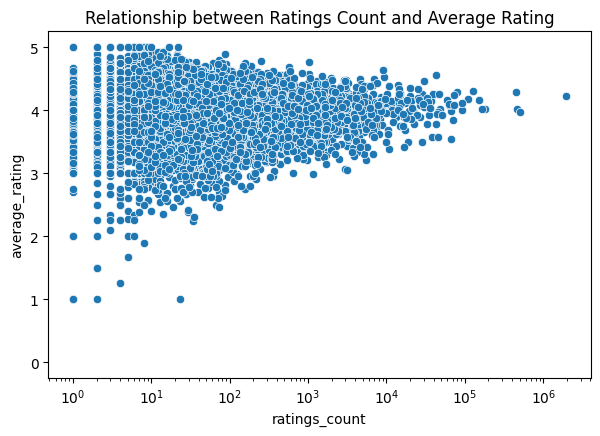

In [69]:
# sample 1% of the data and plot relationship between
# average_rating and ratings_count

sampled_books = en_books.sample(fraction=0.01, seed=42)

sampled_books_df = sampled_books.toPandas()

# convert average_rating and ratings_count to numeric
sampled_books_df["average_rating"] = pd.to_numeric(sampled_books_df["average_rating"])
sampled_books_df["ratings_count"] = pd.to_numeric(sampled_books_df["ratings_count"])


# figure size
plt.figure(figsize=(7, 4.5))
sns.scatterplot(data=sampled_books_df, x="ratings_count", y="average_rating")
# set x to log scale
plt.xscale("log")
plt.title("Relationship between Ratings Count and Average Rating")
plt.show()

From above figure, we can see that average rating converges to 4.0 when the number of ratings is high. This reflects the law of large numbers. In business, it means that the more people rate a book, the more the average rating will converge to the true average rating of the book.

## ETL Pipeline

Now we will build the ETL pipeline. We will perform the following steps:

- Extract the data from the Google Storage bucket
    - books: `goodreads/goodreads_books.json.gz`
    - authors: `goodreads/goodreads_book_authors.json.gz`
    - reviews: `goodreads/goodreads_reviews_dedup.json.gz`
- Transform the data
    - Filter the data to only include English books
    - Join the books and authors data
    - Join the books and reviews data
    - Select the columns that we will use in the search engine
- Load the data into the Google Storage bucket

In [14]:
# we will use en_books dataframe for further analysis
en_books.show(5)

+--------+--------------------+--------------------+-------------+--------------------+---------+----------------+-------------+--------------+-------------+------------------+
| book_id|               title|         description|      authors|                link|num_pages|publication_year|language_code|average_rating|ratings_count|text_reviews_count|
+--------+--------------------+--------------------+-------------+--------------------+---------+----------------+-------------+--------------+-------------+------------------+
| 7327624|The Unschooled Wi...|Omnibus book club...|  [{10333, }]|https://www.goodr...|      600|            1987|          eng|          4.03|          140|                 7|
| 6066819|Best Friends Forever|Addie Downs and V...|   [{9212, }]|https://www.goodr...|      368|            2009|          eng|          3.49|        51184|              3282|
|33394837|The House of Memo...|                    | [{242185, }]|https://www.goodr...|      318|                | 

In [15]:
# check missing values for title, description
check_missing_cols = ["title", "description"]

# missing values is ' ' for string columns not null
# count missing values for each column

for col in check_missing_cols:
    print(f"Missing values for {col}: {en_books.filter(en_books[col] == '').count()}")


Missing values for title: 2
Missing values for description: 75940


In [16]:
# check authors columns as we need to use it to join with other tables

# randomly sample 10 rows from en_books['authors']
en_books.select("authors").sample(fraction=0.01, seed=42).show(10)

+--------------------+
|             authors|
+--------------------+
|       [{5352392, }]|
|       [{4119242, }]|
|       [{2906082, }]|
|[{2765337, }, {27...|
|       [{4667203, }]|
|      [{15502495, }]|
|       [{1899287, }]|
|       [{9873363, }]|
|[{5370407, }, {75...|
|         [{16166, }]|
+--------------------+
only showing top 10 rows



As we can see that `authors` is a list of dictionaries. We will flatten the `authors` column to make it easier to work with. 

In [10]:
from pyspark.sql.functions import explode
en_books_flat = en_books.select("*", explode("authors").alias("author"))

en_books_flat.show(5)

+--------+--------------------+--------------------+-------------+--------------------+---------+----------------+------------+-------------+--------------+-------------+------------------+-----------+
| book_id|               title|         description|      authors|                link|num_pages|publication_year|country_code|language_code|average_rating|ratings_count|text_reviews_count|     author|
+--------+--------------------+--------------------+-------------+--------------------+---------+----------------+------------+-------------+--------------+-------------+------------------+-----------+
| 7327624|The Unschooled Wi...|Omnibus book club...|  [{10333, }]|https://www.goodr...|      600|            1987|          US|          eng|          4.03|          140|                 7|  {10333, }|
| 6066819|Best Friends Forever|Addie Downs and V...|   [{9212, }]|https://www.goodr...|      368|            2009|          US|          eng|          3.49|        51184|              3282|   

In [18]:
# sample 10 rows from en_books_flat to check authors and author columns
# please run this cell multiple times to see different authors
en_books_flat.select("authors", "author") \
    .sample(fraction=0.01).show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------+
|authors                                                                                                                                                                                                                                                                                                                                                                                                          |author                  |
+---------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
# it is important to know that
# author is STRUCT<author_id: STRING, role: STRING>
# now we will use selectExpr to select author_id and role from authors
en_books_auth_id = en_books_flat.selectExpr(
    "author.author_id as author_id",
    "author.role as role",
    "*"
    )

# sample 5 rows to check author_id and role
en_books_auth_id.sample(fraction=0.01).show(5)

+---------+-----------+--------+--------------------+--------------------+--------------------+--------------------+---------+----------------+------------+-------------+--------------+-------------+------------------+-------------------+
|author_id|       role| book_id|               title|         description|             authors|                link|num_pages|publication_year|country_code|language_code|average_rating|ratings_count|text_reviews_count|             author|
+---------+-----------+--------+--------------------+--------------------+--------------------+--------------------+---------+----------------+------------+-------------+--------------+-------------+------------------+-------------------+
|  3413928|           | 7843586|     More (More, #1)|After a series of...|       [{3413928, }]|https://www.goodr...|      245|            2010|          US|          eng|          3.88|         1675|               215|        {3413928, }|
| 14859335|     Editor|30309543|      Sleepl

### Joining the Data

Now we will join the data. We will join `en_books_auth_id` and `authors` dataframes on `author_id` column. We will only use `author_id` and `name` columns from `authors` dataframe.

In [12]:
# now we will read goodreads_author dataset
author_file_path = f"gs://{bucket_name}/goodreads/goodreads_book_authors.json.gz"
authors = spark.read.json(author_file_path)

authors.printSchema()

root
 |-- author_id: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- name: string (nullable = true)
 |-- ratings_count: string (nullable = true)
 |-- text_reviews_count: string (nullable = true)



In [10]:
# check number of rows
print(f"Number of rows in authors: {authors.count()}")

Number of rows in authors: 829529


In [22]:
# have a look at the data
authors.limit(5).toPandas()

,author_id,average_rating,name,ratings_count,text_reviews_count
0,604031,3.98,Ronald J. Fields,49,7
1,626222,4.08,Anita Diamant,546796,28716
2,10333,3.92,Barbara Hambly,122118,5075
3,9212,3.68,Jennifer Weiner,888522,36262
4,149918,3.82,Nigel Pennick,1740,96


In [13]:
# drop average_rating and ratings_count and text_reviews_count from authors

authors = authors.drop("average_rating", "ratings_count", "text_reviews_count")

In [14]:
# join en_books_auth_id with authors on author_id

en_books_authors = en_books_auth_id.join(authors, on="author_id")

en_books_authors.show(5)

+---------+----+--------+--------------------+--------------------+-------------+--------------------+---------+----------------+------------+-------------+--------------+-------------+------------------+-----------+---------------+
|author_id|role| book_id|               title|         description|      authors|                link|num_pages|publication_year|country_code|language_code|average_rating|ratings_count|text_reviews_count|     author|           name|
+---------+----+--------+--------------------+--------------------+-------------+--------------------+---------+----------------+------------+-------------+--------------+-------------+------------------+-----------+---------------+
|    10333|    | 7327624|The Unschooled Wi...|Omnibus book club...|  [{10333, }]|https://www.goodr...|      600|            1987|          US|          eng|          4.03|          140|                 7|  {10333, }| Barbara Hambly|
|     9212|    | 6066819|Best Friends Forever|Addie Downs and V...| 

In [15]:
# counter rows in en_books_authors
print(f"Number of rows in en_books_authors: {en_books_authors.count()}")

Number of rows in en_books_authors: 1249655


### Concatenating authors

After we joining the data, our table grows from around 800K to around 1.2M rows. This is because we have multiple authors for each book. We will concatenate the authors for each book to make it easier to work with. In spark, we can use `concat_ws` function to concatenate the authors. From data engineering perspective, what we are doing is called `group by` and `aggregate`. We are grouping the data by `book_id` and aggregating the data by concatenating the authors.

In [19]:
# group by book_id and then aggregate authors with seperator ';'
from pyspark.sql import functions as F

en_books_authors_grouped = en_books_authors.groupBy(
    "book_id", "title", "description", "link", "language_code",
    "average_rating", "text_reviews_count") \
    .agg(F.concat_ws(";", F.collect_list("name")).alias("authors"))

In [20]:
# check number of rows, we are back to original number of rows
print(f"Number of rows in en_books_authors_grouped: {en_books_authors_grouped.count()}")

Number of rows in en_books_authors_grouped: 866176


In [21]:
# view the data 5 rows
en_books_authors_grouped.show(5)

+--------+--------------------+--------------------+--------------------+-------------+--------------+------------------+--------------------+
| book_id|               title|         description|                link|language_code|average_rating|text_reviews_count|             authors|
+--------+--------------------+--------------------+--------------------+-------------+--------------+------------------+--------------------+
| 1000059|Green Arrow, Vol....|The reinvention o...|https://www.goodr...|        en-US|          4.02|                39|Kevin Smith;Phil ...|
|10000613|Getting Better: W...|As the income gap...|https://www.goodr...|        en-US|          3.61|                15|       Charles Kenny|
|   10002|Three Plays: Invo...|Kobo Abe (1924-19...|https://www.goodr...|          eng|          3.94|                 4|Kobo Abe;Donald K...|
|10005902|Killer on a Hot T...|Delilah Dickinson...|https://www.goodr...|        en-US|          3.54|                 3|   Livia J. Washburn|

In [23]:
# check title is empty
print(f"Number of rows with empty title:\
        {en_books_authors_grouped.filter(en_books_authors_grouped.title == ' ').count()}")

Number of rows with empty title:        0


In [24]:
# now we will read reviews dataset
reviews_file_path = f"gs://{bucket_name}/goodreads/goodreads_reviews_dedup.json.gz"
reviews = spark.read.json(reviews_file_path)

reviews.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- date_updated: string (nullable = true)
 |-- n_comments: long (nullable = true)
 |-- n_votes: long (nullable = true)
 |-- rating: long (nullable = true)
 |-- read_at: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- started_at: string (nullable = true)
 |-- user_id: string (nullable = true)



In [25]:
# check number of rows
print(f"Number of rows in reviews: {reviews.count()}")

Number of rows in reviews: 15739967


In [32]:
# sample 5 rows
reviews.limit(5).toPandas()

,book_id,date_added,date_updated,n_comments,n_votes,rating,read_at,review_id,review_text,started_at,user_id
0,24375664,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,0,16,5,Sat Oct 07 00:00:00 -0700 2017,5cd416f3efc3f944fce4ce2db2290d5e,Mind blowingly cool. Best science fiction I've...,Sat Aug 26 00:00:00 -0700 2017,8842281e1d1347389f2ab93d60773d4d
1,18245960,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,1,28,5,Sat Aug 26 12:05:52 -0700 2017,dfdbb7b0eb5a7e4c26d59a937e2e5feb,This is a special book. It started slow for ab...,Tue Aug 15 13:23:18 -0700 2017,8842281e1d1347389f2ab93d60773d4d
2,6392944,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,0,6,3,Tue Jul 25 00:00:00 -0700 2017,5e212a62bced17b4dbe41150e5bb9037,I haven't read a fun mystery book in a while a...,Mon Jul 24 00:00:00 -0700 2017,8842281e1d1347389f2ab93d60773d4d
3,22078596,Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,4,22,4,Sun Jul 30 15:42:05 -0700 2017,fdd13cad0695656be99828cd75d6eb73,"Fun, fast paced, and disturbing tale of murder...",Tue Jul 25 00:00:00 -0700 2017,8842281e1d1347389f2ab93d60773d4d
4,6644782,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,0,8,4,Sat Aug 05 00:00:00 -0700 2017,bd0df91c9d918c0e433b9ab3a9a5c451,A fun book that gives you a sense of living in...,Sun Jul 30 00:00:00 -0700 2017,8842281e1d1347389f2ab93d60773d4d


In [33]:
# check how many rows where book_id == '24375664'
print(f"Number of rows where book_id == '24375664':\
        {reviews.filter(reviews.book_id == '24375664').count()}")

Number of rows where book_id == '24375664':        25


Each book can have multiple reviews. We will construct a set of good reviews and bad reviews for each book. Different reviews might have different ratings, votes, and comments. This gives rich information about the book, which can be used to build a recommendation system.

### Understanding reviews

For each review, we have three features that could help us to build a recommendation system:

- `rating`: The rating of the review
- `n_votes`: The number of votes the review received
- `n_comments`: The number of comments the review received

We will first sample some data to understand the relationship between these features.

In [31]:
# sample 0.01% of the data and plot relationship between
# n_votes and n_comments

sampled_reviews = reviews.sample(fraction=0.0001, seed=42)

# cache the dataframe
sampled_reviews.cache()

# show 5 rows
sampled_reviews.show(5)

+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
| book_id|          date_added|        date_updated|n_comments|n_votes|rating|             read_at|           review_id|         review_text|          started_at|             user_id|
+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 6068551|Tue Aug 11 13:10:...|Mon Sep 07 13:10:...|         4|      2|     0|                    |d054a81d6ec4cc929...|Jackie says: \n T...|                    |b62e7452ce0cebbd1...|
|12820360|Tue Feb 25 18:31:...|Wed Feb 26 19:25:...|         0|      0|     4|Wed Feb 26 19:22:...|172d265dedd6ba367...|This is a light, ...|Tue Feb 25 00:00:...|9fb3243336a3c406f...|
|16150830|Thu Aug 01 13:56:...|Thu Feb 25 23:58:...|         0|      0|     5|Tu

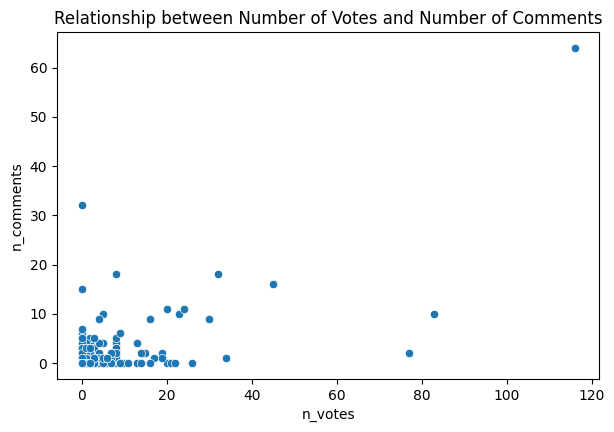

In [32]:
# plot relationship between n_votes and n_comments
sampled_reviews_df = sampled_reviews.toPandas()

# convert n_votes and n_comments to numeric
sampled_reviews_df["n_votes"] = pd.to_numeric(sampled_reviews_df["n_votes"])
sampled_reviews_df["n_comments"] = pd.to_numeric(sampled_reviews_df["n_comments"])

# figure size
plt.figure(figsize=(7, 4.5))
sns.scatterplot(data=sampled_reviews_df, x="n_votes", y="n_comments")
plt.title("Relationship between Number of Votes and Number of Comments")
plt.show()

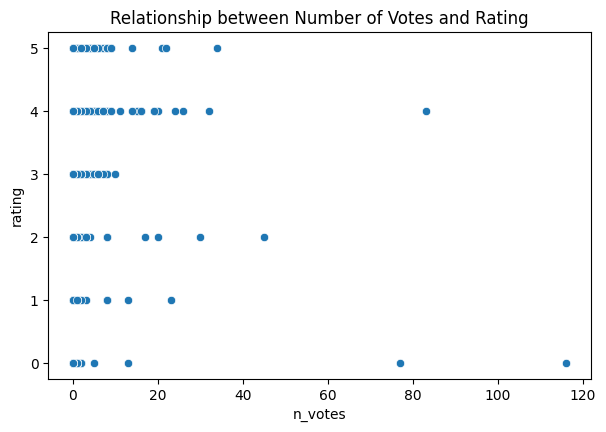

In [33]:
# plot relationship between n_votes and rating
# figure size
plt.figure(figsize=(7, 4.5))
sns.scatterplot(data=sampled_reviews_df, x="n_votes", y="rating")
plt.title("Relationship between Number of Votes and Rating")
plt.show()

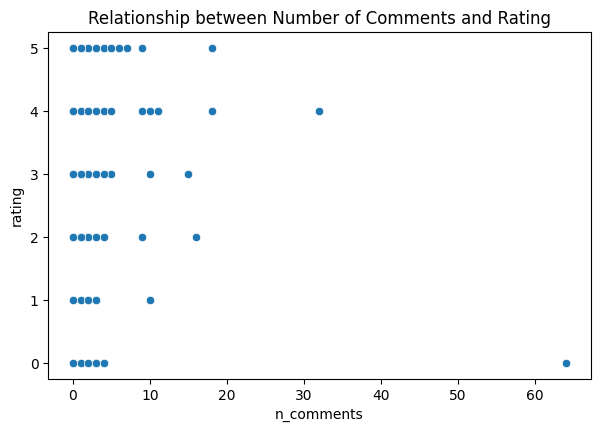

In [34]:
# show relationship between n_comments and rating
# figure size
plt.figure(figsize=(7, 4.5))
sns.scatterplot(data=sampled_reviews_df, x="n_comments", y="rating")
plt.title("Relationship between Number of Comments and Rating")
plt.show()

There is a positive correlation between the number of votes and the number of comments. __For the relationship between the rating and the number of votes, one has to be very careful__. In our books table, we have `average_rating` column, which is calculated from the rating column of the reviews table. Therefore, we should not use the rating column of the reviews table to build a recommendation system. Instead, we should use the `average_rating` column of the books table.

Based on goodreads website, `n_votes` is the number of likes the review received.
There are many interesting things could be discovered from the reviews data. For instance:

- if the review deviates from the average rating, will it get more or less votes?
- if the review deviates from the average rating, will it get more or less comments?
- how does the radicalness of the review affect the number of votes and comments?

We will explore these questions in the future.

### Transforming the reviews data

To transform the reviews data, we will borrow the philosophy of TF-IDF, meaning we will:

- calcualte the sum of the `n_votes` and `n_comments` for each book
- calculate the average of the `rating` for each book
- calculate the deviation of the `rating` from the `average_rating` for each book
- calculate the length of the review for each book

In [35]:
# calculate the sum of n_votes and n_comments for each row
# and add a new column called total_engagement and add it to
# reviews dataframe
reviews = reviews.withColumn("total_engagement", reviews.n_votes + reviews.n_comments)

In [36]:
# view 5 rows
reviews.show(5)

+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+
| book_id|          date_added|        date_updated|n_comments|n_votes|rating|             read_at|           review_id|         review_text|          started_at|             user_id|total_engagement|
+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+
|24375664|Fri Aug 25 13:55:...|Mon Oct 09 08:55:...|         0|     16|     5|Sat Oct 07 00:00:...|5cd416f3efc3f944f...|Mind blowingly co...|Sat Aug 26 00:00:...|8842281e1d1347389...|              16|
|18245960|Sun Jul 30 07:44:...|Wed Aug 30 00:00:...|         1|     28|     5|Sat Aug 26 12:05:...|dfdbb7b0eb5a7e4c2...|This is a special...|Tue Aug 15 13:23:...|8842281e1d1347389...|             

In [37]:
# add new column called 'average_rating' to reviews dataframe
# by calculating the average rating for each book_id
# and join it with reviews dataframe

# group by book_id and calculate average rating
average_rating = en_books_authors_grouped.groupBy("book_id") \
    .agg(F.mean("average_rating").alias("average_rating"))
    
# join average_rating with reviews dataframe
reviews = reviews.join(average_rating, on="book_id")

# view 5 rows
reviews.show(5)

+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+
| book_id|          date_added|        date_updated|n_comments|n_votes|rating|             read_at|           review_id|         review_text|          started_at|             user_id|total_engagement|average_rating|
+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+
|10000761|Tue Apr 02 20:16:...|Tue Apr 02 20:26:...|         0|      0|     3|Tue Apr 02 00:00:...|5dcb02a5a8228a2be...|A fascinating rea...|                    |b77f34246ac69b4b6...|               0|           3.5|
|10000761|Sat Sep 10 16:19:...|Sat Sep 10 16:33:...|         2|      1|     5|Sat Sep 10 00:00:...|abae93ad132fef34f...|Jason Berry has 

In [38]:
# add a new column called `length_of_review` to reviews dataframe
# by calculating the length of review_text

reviews = reviews.withColumn("length_of_review", F.length(reviews.review_text))

# view 5 rows
reviews.show(5)

+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+
| book_id|          date_added|        date_updated|n_comments|n_votes|rating|             read_at|           review_id|         review_text|          started_at|             user_id|total_engagement|average_rating|length_of_review|
+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+
|10000761|Tue Apr 02 20:16:...|Tue Apr 02 20:26:...|         0|      0|     3|Tue Apr 02 00:00:...|5dcb02a5a8228a2be...|A fascinating rea...|                    |b77f34246ac69b4b6...|               0|           3.5|             548|
|10000761|Sat Sep 10 16:19:...|Sat Sep 10 16:33:...|         2|     

In [39]:
# now sample 0.05% of the data and plot relationship between
# lenght_of_review and n_votes
sampled_reviews2 = reviews.sample(fraction=0.0005, seed=42)

# cache the dataframe
sampled_reviews2.cache()

# show 5 rows
sampled_reviews2.show(5)

+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+
| book_id|          date_added|        date_updated|n_comments|n_votes|rating|             read_at|           review_id|         review_text|          started_at|             user_id|total_engagement|average_rating|length_of_review|
+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+
|  140082|Fri Sep 28 21:41:...|Fri Nov 18 19:49:...|         0|      0|     5|Tue Oct 02 15:06:...|dadeb0515c02e28b2...|I liked this book...|Fri Sep 28 00:00:...|a161ad57be460d36f...|               0|          4.03|             487|
|15734715|Thu Aug 13 19:16:...|Mon Feb 29 06:17:...|         0|     

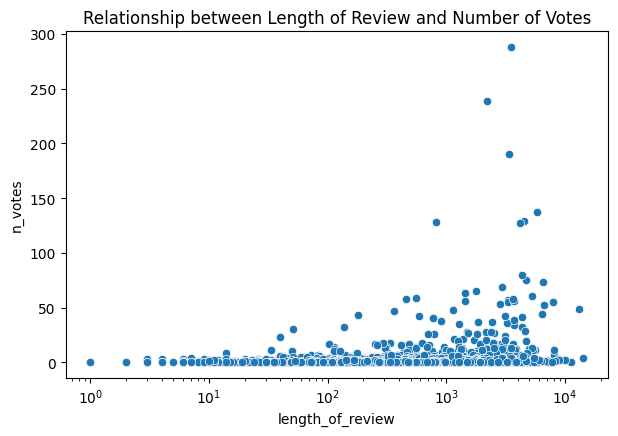

In [44]:
# plot the relationship between length_of_review and n_votes
sampled_reviews2_df = sampled_reviews2.toPandas()

# convert length_of_review and n_votes to numeric
sampled_reviews2_df["length_of_review"] = pd.to_numeric(sampled_reviews2_df["length_of_review"])
sampled_reviews2_df["n_votes"] = pd.to_numeric(sampled_reviews2_df["n_votes"])

# figure size
plt.figure(figsize=(7, 4.5))
sns.scatterplot(data=sampled_reviews2_df, x="length_of_review", y="n_votes")
# set x to log scale
plt.xscale("log")
plt.title("Relationship between Length of Review and Number of Votes")
plt.show()

As you can see that there is some positive relationship between length of review and number of votes. However, we also have a huge amount of _slient majority_ who do not vote or comment on the reviews. This is a common phenomenon in the internet. People are more likely to vote or comment when they disagree with the review. This is called the _vocal minority_. 

__There is also another factor we have think about when building a recommendation system__. Popular books are more likely to have more reviews. Popular books are also receive longer reviews. Therefore, we should normalize the length of the review by the popularity of the book. Meaning we will do the following:

First, let's normalize the length of the reviews. This normalization will ensure that the length is factored in without overly penalizing or favoring long or short reviews.

- $L_{i}^g$: Length of the $i$-th review for a book that belongs to the $g$-th group (sharing the same `book_id`).
- $L_{\text{max}}^g$: Maximum length of all reviews.
- $L_{\text{min}}^g$: Minimum length of all reviews.

Normalize the length of a review to a range between 0 and 1:

$$ \text{Normalized Length} (NL_i) = \frac{L_i^g - L_{\text{min}}^g}{L_{\text{max}}^g - L_{\text{min}}^g} $$


In [45]:
# find the maximum length of review_text within group that has
# the same book_id
max_length_of_review = reviews.groupBy("book_id") \
    .agg(F.max("length_of_review").alias("max_length_of_review"))
# find the minimum length of review_text within group that has
# the same book_id

min_length_of_review = reviews.groupBy("book_id") \
    .agg(F.min("length_of_review").alias("min_length_of_review"))

# you can do the above two steps in one line
# length_of_review_stats = reviews.groupBy("book_id") \
#     .agg(F.max("length_of_review").alias("max_length_of_review"),
#          F.min("length_of_review").alias("min_length_of_review"))
# and then join it with reviews dataframe
# reviews = reviews.join(length_of_review_stats, on="book_id")
    
# join max_length_of_review and min_length_of_review with reviews dataframe

reviews = reviews.join(max_length_of_review, on="book_id") \
    .join(min_length_of_review, on="book_id")
    
# view 5 rows
reviews.show(5)

+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+--------------------+--------------------+
| book_id|          date_added|        date_updated|n_comments|n_votes|rating|             read_at|           review_id|         review_text|          started_at|             user_id|total_engagement|average_rating|length_of_review|max_length_of_review|min_length_of_review|
+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+--------------------+--------------------+
|10000761|Tue Apr 02 20:16:...|Tue Apr 02 20:26:...|         0|      0|     3|Tue Apr 02 00:00:...|5dcb02a5a8228a2be...|A fascinating rea...|                    |b77f34246ac69

In [46]:
# normalize length_of_review column
reviews = reviews.withColumn(
    "normalized_length_of_review",
    F.when(
        # max != min
        F.col("max_length_of_review") != F.col("min_length_of_review"),
        # normalize
        (F.col("length_of_review") - F.col("min_length_of_review")) / (F.col("max_length_of_review") - F.col("min_length_of_review"))
    ).otherwise(0)
)

# view 5 rows
reviews.show(5)

+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+--------------------+--------------------+---------------------------+
| book_id|          date_added|        date_updated|n_comments|n_votes|rating|             read_at|           review_id|         review_text|          started_at|             user_id|total_engagement|average_rating|length_of_review|max_length_of_review|min_length_of_review|normalized_length_of_review|
+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+--------------------+--------------------+---------------------------+
|10000761|Tue Apr 02 20:16:...|Tue Apr 02 20:26:...|         0|      0|     3|Tue Apr 02 00

In [ ]:
# now let's sample 0.05% of the data and plot relationship between
# normalized_length_of_review and n_votes
sampled_reviews3 = reviews.sample(fraction=0.0005, seed=42)
# cache the dataframe
sampled_reviews3.cache()
# show 5 rows
sampled_reviews3.show(5)

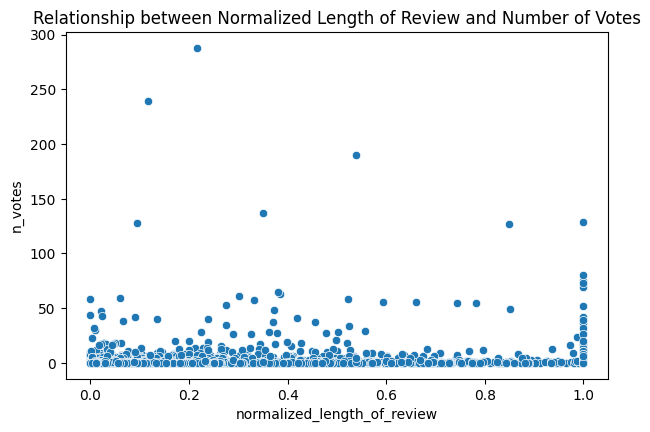

In [48]:
# plot the relationship between normalized_length_of_review and n_votes
sampled_reviews3_df = sampled_reviews3.toPandas()

# convert normalized_length_of_review and n_votes to numeric
sampled_reviews3_df["normalized_length_of_review"] = pd.to_numeric(sampled_reviews3_df["normalized_length_of_review"])
sampled_reviews3_df["n_votes"] = pd.to_numeric(sampled_reviews3_df["n_votes"])

# figure size
plt.figure(figsize=(7, 4.5))
sns.scatterplot(data=sampled_reviews3_df, x="normalized_length_of_review", y="n_votes")
plt.title("Relationship between Normalized Length of Review and Number of Votes")
plt.show()

As we can see that there is still _silent majority_ who do not vote or comment on the reviews even after normalization. This is a common phenomenon in the internet. People are more likely to vote or comment when they disagree with the review. This is called the _vocal minority_.

### Construct a simple review quality score

We will construct a simple review quality score for each book. We will use the following formula:

$$ \text{Review Quality Score} = 0.3 \times (1- \text{Normalized Length}) + 0.7 \times \text{Total Engagement} $$

Where:

- $\text{Normalized Length}$: The normalized length of the review
- $\text{Total Engagement}$: The sum of the votes and comments

In [49]:
# get rows from reviews where number of rows for each book_id
# is 1, meaning there is only one review for that book_id
single_review = reviews.groupBy("book_id") \
    .agg(F.count("book_id").alias("n_reviews")) \
    .filter(F.col("n_reviews") == 1)
    
# view 5 rows
single_review.show(5)

+--------+---------+
| book_id|n_reviews|
+--------+---------+
|10013815|        1|
|10018748|        1|
|10023340|        1|
|10035900|        1|
|10042861|        1|
+--------+---------+
only showing top 5 rows



In [50]:
# count number of rows
print(f"Number of rows in single_review: {single_review.count()}")

Number of rows in single_review: 301757


In [51]:
# get rows from reviews where number of rows for each book_id
# is greater than 1, meaning there is more than one review for that book_id

multiple_reviews = reviews.groupBy("book_id") \
    .agg(F.count("book_id").alias("n_reviews")) \
    .filter(F.col("n_reviews") > 1)
    
# view 5 rows
multiple_reviews.show(5)

+--------+---------+
| book_id|n_reviews|
+--------+---------+
|10000600|       23|
|10000761|        4|
| 1000096|        2|
|10001383|       22|
|10001793|        4|
+--------+---------+
only showing top 5 rows



In [52]:
# get the table from reviews where book_id is in single_review

single_review_table = reviews.join(single_review, on="book_id")
# view 5 rows
single_review_table.show(5)

+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+--------------------+--------------------+---------------------------+---------+
| book_id|          date_added|        date_updated|n_comments|n_votes|rating|             read_at|           review_id|         review_text|          started_at|             user_id|total_engagement|average_rating|length_of_review|max_length_of_review|min_length_of_review|normalized_length_of_review|n_reviews|
+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+--------------------+--------------------+---------------------------+---------+
|10013815|Sun Oct 21 23:14:...|Thu Mar 06 16:11:...|         

In [ ]:
# get the table from reviews where book_id is in multiple_reviews
reviews_multiple = reviews.join(multiple_reviews, on="book_id")
print(f"Number of rows in reviews_multiple: {reviews_multiple.count()}")

In [54]:
# construct the review_score for reviews_multiple
# review_score = 0.3 * normalized_length_of_review + 0.7 * total_engagement
# meaning we give 30% weight to normalized_length_of_review
# and 70% weight to total_engagement
reviews_multiple = reviews_multiple.withColumn(
    "review_score",
    0.3 * F.col("normalized_length_of_review") + 0.7 * F.col("total_engagement")
)

# view 5 rows
reviews_multiple.show(5)

+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+--------------------+--------------------+---------------------------+---------+-------------------+
| book_id|          date_added|        date_updated|n_comments|n_votes|rating|             read_at|           review_id|         review_text|          started_at|             user_id|total_engagement|average_rating|length_of_review|max_length_of_review|min_length_of_review|normalized_length_of_review|n_reviews|       review_score|
+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+--------------------+--------------------+---------------------------+---------+-------------------+
|

In [ ]:
# rank the review_score after partitioning by book_id
from pyspark.sql.window import Window
windowSpec = Window.partitionBy("book_id").orderBy(F.desc("review_score"))
reviews_multiple = reviews_multiple.withColumn(
    "rank",
    F.rank().over(windowSpec)
)

# within each book_id, we will only keep the top 2 reviews
reviews_multiple_top2 = reviews_multiple.filter(F.col("rank") <= 2)

# print number of rows
print(f"Number of rows in reviews_multiple_top2: {reviews_multiple_top2.count()}")

In [56]:
# view 5 rows
reviews_multiple_top2.show(5)

+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+--------------------+--------------------+---------------------------+---------+-------------------+----+
| book_id|          date_added|        date_updated|n_comments|n_votes|rating|             read_at|           review_id|         review_text|          started_at|             user_id|total_engagement|average_rating|length_of_review|max_length_of_review|min_length_of_review|normalized_length_of_review|n_reviews|       review_score|rank|
+--------+--------------------+--------------------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+----------------+--------------------+--------------------+---------------------------+---------+------------

In [57]:
# now we will select only the columns that we need
# from both single_review_table and reviews_multiple_top2
selected_columns = [
    "book_id", "review_text", "n_votes", "total_engagement"
]

single_review_table = single_review_table.select(selected_columns)
reviews_multiple_top2 = reviews_multiple_top2.select(selected_columns)

In [ ]:
# union single_review_table and reviews_multiple_top2
reviews_combined = single_review_table.union(reviews_multiple_top2)
# print number of rows
print(f"Number of rows in reviews_combined: {reviews_combined.count()}")

In [59]:
# view 5 rows
reviews_combined.show(5)

+--------+--------------------+-------+----------------+
| book_id|         review_text|n_votes|total_engagement|
+--------+--------------------+-------+----------------+
|10013815|Honestly, I wasn'...|      0|               0|
|10076589|Not been my favou...|      0|               0|
|10080772|What an interesti...|      0|               0|
|10086567|Who am I to rate ...|      0|               0|
|10094586|Always a fun seri...|      0|               0|
+--------+--------------------+-------+----------------+
only showing top 5 rows



## Construct the final dataset

Now we will construct the final dataset. We will select the following columns:

- book_id
- title
- name (author)
- description
- link
- review_text
- text_reviews_count
- average_rating
- ratings_count
- author_id

In [60]:
# join en_books_authors with book_reviews on book_id
en_books_authors_grouped.show(5)

+--------+--------------------+--------------------+--------------------+-------------+--------------+------------------+--------------------+
| book_id|               title|         description|                link|language_code|average_rating|text_reviews_count|             authors|
+--------+--------------------+--------------------+--------------------+-------------+--------------+------------------+--------------------+
| 1000059|Green Arrow, Vol....|The reinvention o...|https://www.goodr...|        en-US|          4.02|                39|Kevin Smith;Phil ...|
|10000613|Getting Better: W...|As the income gap...|https://www.goodr...|        en-US|          3.61|                15|       Charles Kenny|
|   10002|Three Plays: Invo...|Kobo Abe (1924-19...|https://www.goodr...|          eng|          3.94|                 4|Kobo Abe;Donald K...|
|10005902|Killer on a Hot T...|Delilah Dickinson...|https://www.goodr...|        en-US|          3.54|                 3|   Livia J. Washburn|

In [ ]:
# now we want to join en_books_authors_grouped with reviews_combined
# on book_id, but we will do left join
# because we want to keep all rows from en_books_authors_grouped
en_books_reviews = en_books_authors_grouped.join(reviews_combined, on="book_id", how="left")

# print number of rows
print(f"Number of rows in en_books_reviews: {en_books_reviews.count()}")

In [62]:
# select book_id, title, name, description, link
# review_text, average_rating, ratings_count, author_id

selected_columns = [
    "book_id", "title", "authors", "description", "link",
    "review_text", "text_reviews_count", "average_rating"
]

final_df = en_books_reviews.select(selected_columns)

In [ ]:
# sample 5 rows
final_df.show(5)

In [ ]:
# check how many rows where review_text is empty
print(f"Number of rows where review_text is empty:\
        {final_df.filter(final_df.review_text == '').count()}")

In [65]:
# now create new column called 'setence' 
# by concatenating review_text, title, description, author
# and make sure setence is in lower case
# WARNING: we suppose to add '[SEP]' between each column
# but we will not do it here
from pyspark.sql.functions import concat_ws, lower

final_df = final_df.withColumn(
    "sentence",
    lower(concat_ws("[SEP]", "review_text", "title", "description", "authors"))
)

In [ ]:
# have a look at the data
final_df.show(5)

In [ ]:
# write final_df to parquet file with snappy compression
# called {current_date}_training.parquet
current_date = date.today().strftime("%Y%m%d")

# save parquet file to local disk
final_df.write.option("compression", "snappy") \
    .parquet(f"{current_date}_training.parquet")

In [ ]:
# save parquet file to GCS
final_df.write.option("compression", "snappy") \
    .mode("overwrite") \
    .parquet(f"gs://{bucket_name}/goodreads/{current_date}_training.parquet")

In [69]:
# stop spark session
spark.stop()

## Remarks


To construct a metric for recommending good reviews based on the given conditions, we can develop a formula that balances the length of the review, the number of votes (likes), the number of comments, and the content tone. Below are possible metrics and their corresponding formulas:

### 1. Review Length Normalization
First, let's normalize the length of the reviews. This normalization will ensure that the length is factored in without overly penalizing or favoring long or short reviews.

- $L_i$: Length of the $i$-th review.
- $L_{\text{max}}$: Maximum length of all reviews.
- $L_{\text{min}}$: Minimum length of all reviews.

Normalize the length of a review to a range between 0 and 1:

$$ \text{Normalized Length} (NL_i) = \frac{L_i - L_{\text{min}}}{L_{\text{max}} - L_{\text{min}}} $$

### 2. Engagement Metric
Combine the number of votes and comments to create an engagement metric.

- $V_i$: Number of votes for the $i$-th review.
- $C_i$: Number of comments for the $i$-th review.

We can sum these two metrics or use a weighted sum if votes are considered more important than comments:

$$ \text{Engagement} (E_i) = V_i + w \cdot C_i $$

Where $w$ is a weight parameter (e.g., $w = 0.5$ if votes are twice as important as comments).

###  3. Sentiment Analysis
To measure the tone of the review, we need to perform sentiment analysis to quantify how radical or balanced the review is.

- $S_i$: Sentiment score for the $i$-th review (range from -1 to 1, where -1 is very negative, 0 is neutral, and 1 is very positive).

### 4. Combined Metric
We want to balance the normalized length, engagement, and sentiment to form a single metric. Here’s a possible formula:

$$ \text{Review Quality} (Q_i) = \alpha \cdot (1 - NL_i) + \beta \cdot E_i + \gamma \cdot (1 - |S_i|) $$

Where:
- $\alpha$, $\beta$, and $\gamma$ are weights that can be tuned based on the importance of each factor.
- $1 - NL_i$: Penalizes longer reviews, giving higher scores to shorter reviews.
- $E_i$: Reflects the engagement of the review.
- $1 - |S_i|$: Rewards less radical (more neutral) reviews, as extreme sentiments are penalized.

### Example Values
Let’s consider some example values:
- $\alpha = 0.3$
- $\beta = 0.5$
- $\gamma = 0.2$

This configuration means engagement is the most important factor, followed by review length, and then sentiment neutrality.

### Summary
1. **Normalize the review length** to account for varying lengths.
2. **Combine votes and comments** into an engagement metric.
3. **Analyze the sentiment** of the review to ensure it's not too radical.
4. **Combine these factors** into a single quality score with appropriate weights.

You can adjust the weights ($\alpha$, $\beta$, and $\gamma$) according to the specific needs and goals of your recommendation system. Additionally, these metrics can be refined further based on feedback and testing.